### Load Module

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os 
import pandas as pd
import numpy as np

import torch
import pickle

from torch_geometric.data import Dataset, download_url, DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool, SAGPooling, GATConv, JumpingKnowledge, ASAPooling, GlobalAttention
from torch.optim import Adam
import copy

import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

from sksurv.metrics import concordance_index_censored

import torch.nn as nn
import torch.nn.functional as F

### Load Clinical Data

- TCGA

In [2]:
WSI_TCGA_info = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/WSI/wsi_metadata_with_patches_and_embeddings_and_graphs.csv",index_col=0)
WSI_TCGA_info

,bcr_patient_barcode,age_at_diagnosis,cigarettes_per_day,primary_diagnosis,tissue_or_organ_of_origin,ajcc_pathologic_stage,race,gender,prior_malignancy,vital_status,ajcc_pathologic_t,ajcc_pathologic_n,ajcc_pathologic_m,survival_time,patches_npy,patches_pkl,embeddings,graphs
0,TCGA-2F-A9KO,63.898630,3.780822,Transitional cell carcinoma,Posterior wall of bladder,Stage IV,white,male,no,1,T3,N1,M0,734.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
1,TCGA-2F-A9KP,66.926027,3.397260,Transitional cell carcinoma,Lateral wall of bladder,Stage IV,white,male,no,1,T3a,N2,MX,364.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
2,TCGA-2F-A9KP,66.926027,3.397260,Transitional cell carcinoma,Lateral wall of bladder,Stage IV,white,male,no,1,T3a,N2,MX,364.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
3,TCGA-2F-A9KQ,69.202740,0.000000,Transitional cell carcinoma,"Bladder, NOS",Stage III,white,male,no,0,T3a,N0,M0,2886.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
4,TCGA-2F-A9KR,59.857534,1.232877,Papillary transitional cell carcinoma,"Bladder, NOS",Stage III,not reported,female,no,1,T3a,N0,M0,3183.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,TCGA-ZF-AA54,71.583562,0.000000,Transitional cell carcinoma,Lateral wall of bladder,Stage III,white,male,no,1,T3,NX,MX,590.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
452,TCGA-ZF-AA58,61.778082,2.136986,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,female,no,0,T3a,N2,MX,1649.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
453,TCGA-ZF-AA5H,60.608219,0.438356,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,female,no,0,T3b,N2,M0,897.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...
454,TCGA-ZF-AA5N,62.304110,0.547945,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,female,no,1,T2,NX,M1,168.0,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...


In [3]:
WSI_TCGA_info.patches_npy[1]

'/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/TristanD/Data/BLCA_WSI/patches_1_224_downsampled/TCGA-2F-A9KP-01Z-00-DX1.3CDF534E-958F-4467-AA7E-FD3C5A86AAAA.npy'

In [4]:
WSI_TCGA_info.graphs[1]

'/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/WSI/Graph_Generating/Graphs/TCGA-2F-A9KP-01Z-00-DX1.3CDF534E-958F-4467-AA7E-FD3C5A86AAAA.pkl'

#### Get Demogrphics and Tumor stage of TCGA, then, Convert categorical variables into dummy variables

In [5]:
TCGA_Pheno = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/BLCA_TCGA_meta_data.csv").sort_values(by='bcr_patient_barcode', ascending=True).reset_index(drop=True)
TCGA_Pheno = TCGA_Pheno[['bcr_patient_barcode', 'age_at_diagnosis', 'gender', 'ajcc_pathologic_stage']].copy()
TCGA_Pheno.rename({'age_at_diagnosis': 'Age',
                   'gender': 'Gender',
                   'ajcc_pathologic_stage': 'Tumor_Stage'}, axis=1, inplace=True)
TCGA_Pheno.replace({'Tumor_Stage': {"0": 'cis_Stage_0',
                                    'Stage I':'Stage_I', 'Stage II':'Stage_II',
                                    'Stage III':'Stage_III', 'Stage IV':'Stage_IV'},
                    'Gender':{'female':0, 'male':1}}, inplace = True)

TCGA_Pheno = TCGA_Pheno.drop_duplicates()

stand = StandardScaler()
TCGA_Pheno['Age_stand'] = stand.fit_transform(TCGA_Pheno['Age'].values.reshape(-1,1))

TCGA_Pheno_Dummy = pd.get_dummies(TCGA_Pheno, columns=['Tumor_Stage'],
                                  drop_first=False, prefix=['Stage'])

TCGA_Pheno_Dummy

,bcr_patient_barcode,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,TCGA-2F-A9KO,63.898630,1,-0.408341,0,0,0,1,0
1,TCGA-2F-A9KP,66.926027,1,-0.135424,0,0,0,1,0
2,TCGA-2F-A9KQ,69.202740,1,0.069820,0,0,1,0,0
3,TCGA-2F-A9KR,59.857534,0,-0.772643,0,0,1,0,0
4,TCGA-2F-A9KT,83.616438,1,1.369205,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
407,TCGA-ZF-AA56,79.279452,0,0.978229,0,0,1,0,0
408,TCGA-ZF-AA58,61.778082,0,-0.599507,0,0,0,1,0
409,TCGA-ZF-AA5H,60.608219,0,-0.704970,0,0,0,1,0
410,TCGA-ZF-AA5N,62.304110,0,-0.552086,0,0,0,1,0


- Merge DNAm and Phenotype

In [6]:
WSI_TCGA_info = WSI_TCGA_info.merge(TCGA_Pheno_Dummy, left_on="bcr_patient_barcode", right_on="bcr_patient_barcode", how="left")
WSI_TCGA_info

,bcr_patient_barcode,age_at_diagnosis,cigarettes_per_day,primary_diagnosis,tissue_or_organ_of_origin,ajcc_pathologic_stage,race,gender,prior_malignancy,vital_status,...,embeddings,graphs,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,TCGA-2F-A9KO,63.898630,3.780822,Transitional cell carcinoma,Posterior wall of bladder,Stage IV,white,male,no,1,...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,63.898630,1,-0.408341,0,0,0,1,0
1,TCGA-2F-A9KP,66.926027,3.397260,Transitional cell carcinoma,Lateral wall of bladder,Stage IV,white,male,no,1,...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,66.926027,1,-0.135424,0,0,0,1,0
2,TCGA-2F-A9KP,66.926027,3.397260,Transitional cell carcinoma,Lateral wall of bladder,Stage IV,white,male,no,1,...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,66.926027,1,-0.135424,0,0,0,1,0
3,TCGA-2F-A9KQ,69.202740,0.000000,Transitional cell carcinoma,"Bladder, NOS",Stage III,white,male,no,0,...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,69.202740,1,0.069820,0,0,1,0,0
4,TCGA-2F-A9KR,59.857534,1.232877,Papillary transitional cell carcinoma,"Bladder, NOS",Stage III,not reported,female,no,1,...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,59.857534,0,-0.772643,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,TCGA-ZF-AA54,71.583562,0.000000,Transitional cell carcinoma,Lateral wall of bladder,Stage III,white,male,no,1,...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,71.583562,1,0.284450,0,0,1,0,0
452,TCGA-ZF-AA58,61.778082,2.136986,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,female,no,0,...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,61.778082,0,-0.599507,0,0,0,1,0
453,TCGA-ZF-AA5H,60.608219,0.438356,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,female,no,0,...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,60.608219,0,-0.704970,0,0,0,1,0
454,TCGA-ZF-AA5N,62.304110,0.547945,Transitional cell carcinoma,"Bladder, NOS",Stage IV,white,female,no,1,...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Inte...,62.304110,0,-0.552086,0,0,0,1,0


- Check Na numbers in each column

In [7]:
WSI_TCGA_info.isna().sum()

bcr_patient_barcode          0
age_at_diagnosis             0
cigarettes_per_day           0
primary_diagnosis            0
tissue_or_organ_of_origin    0
ajcc_pathologic_stage        0
race                         0
gender                       0
prior_malignancy             0
vital_status                 0
ajcc_pathologic_t            0
ajcc_pathologic_n            0
ajcc_pathologic_m            0
survival_time                0
patches_npy                  0
patches_pkl                  0
embeddings                   0
graphs                       0
Age                          0
Gender                       0
Age_stand                    0
Stage_Stage_I                0
Stage_Stage_II               0
Stage_Stage_III              0
Stage_Stage_IV               0
Stage_cis_Stage_0            0
dtype: int64

#### Split Dataset into training and testing set

In [8]:
y = WSI_TCGA_info['gender'].copy()
WSI_TCGA_info_train, WSI_TCGA_info_val, y_train, y_val = train_test_split(WSI_TCGA_info, y, 
                                                                          random_state=2,
                                                                          test_size=0.2)
# training: testing = 4:1 (N = 364 vs N = 92)

- DH

In [9]:
clinical_DH_df = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_DNAm_HiTIMED/Total_88_subjects_WSI_Pheno_HiTIMED.csv")
clinical_DH_df = clinical_DH_df.dropna(subset=['file_name'])
clinical_DH_df = clinical_DH_df[clinical_DH_df['file_name'] != '205943_.svs'] # "205943_.pkl" < 810 byte
clinical_DH_df = clinical_DH_df.drop('Age', axis=1)
clinical_DH_df

,FFPE.DNA.ID,Blood.Sample.ID,ChIP_ID_Blood,Batch,Sex,Grade,Grade2,Muscle_Invasive,BCG,ImToBlood,...,CD4mem,Treg,CD8nv,CD8mem,Mono,DC,NK,Bas,Eos,Neu
0,BLD050,A00000FBK,203723190040_R08C01,Batch_3,male,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.000000,5.580140,0.0,3.388986,0.000000,0.000000,2.652840,0.000000,0.000000,0.0
1,BLD043,A00000FC3,203752100070_R04C01,Batch_2,female,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.185204,1.613221,0.0,3.676642,1.383615,5.232480,1.701208,0.000000,0.000000,0.0
2,BLD043,A00000FC3,203752100070_R04C01,Batch_2,female,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.185204,1.613221,0.0,3.676642,1.383615,5.232480,1.701208,0.000000,0.000000,0.0
3,BLD061,A00000EH7,203789410029_R03C01,Batch_3,female,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.997968,1.589810,0.0,3.141940,0.000000,4.534836,2.254315,0.073649,0.205418,0.0
4,BLD061,A00000EH7,203789410029_R03C01,Batch_3,female,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.997968,1.589810,0.0,3.141940,0.000000,4.534836,2.254315,0.073649,0.205418,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,BLD048,BDB1P03023,202163530099_R07C01,Batch_1,male,grade 2,Grade 1 + 2,no,Without Immuno,NaN,...,2.428655,1.116786,0.0,2.827982,0.000000,0.000000,1.453588,0.618560,0.974700,0.0
137,BLD075,BDB1P04022,202172220150_R06C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,1.010792,2.579993,0.0,0.000000,0.000000,0.000000,0.000000,2.200406,0.000000,0.0
138,BLD024,BDB1P02094,202163530080_R06C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,1.592609,2.059939,0.0,1.649354,3.207488,0.000000,0.704491,0.724507,0.487317,0.0
139,BLD094,BDB1P03058,202163550181_R02C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.620439,0.556929,0.0,1.327215,0.388502,0.000000,0.000000,0.287847,0.132852,0.0


#### Load DH phenotype

In [10]:
DH_pheno = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_DNAm_HiTIMED/Total_88_subjects_WSI_Pheno_HiTIMED.csv")
DH_pheno = DH_pheno.loc[:,['FFPE.DNA.ID', 'Age', 'Sex', 'stage2']]
DH_pheno = DH_pheno.drop_duplicates()
DH_pheno.rename({'Sex': 'Gender',
                 'stage2': 'Tumor_Stage'}, axis=1, inplace=True)
DH_pheno.replace({'Tumor_Stage': {"cis + stage 0a": 'cis_Stage_0',
                                  'stage I':'Stage_I', 'stage II':'Stage_II',
                                  'stage III':'Stage_III', 'stage IV':'Stage_IV'},
                  'Gender':{'female':0, 'male':1}}, inplace = True)

DH_pheno = DH_pheno[['FFPE.DNA.ID', 'Age', 'Gender', 'Tumor_Stage']].copy()
DH_pheno['Age_stand'] = stand.transform(DH_pheno['Age'].values.reshape(-1,1))
DH_pheno = pd.get_dummies(DH_pheno, columns=['Tumor_Stage'],
                          drop_first=False, prefix=['Stage'])
DH_pheno

,FFPE.DNA.ID,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,BLD050,77,1,0.772738,0,0,0,0,1
1,BLD043,77,0,0.772738,1,0,0,0,0
3,BLD061,76,0,0.682589,0,0,0,0,1
5,BLD046,69,1,0.051544,0,0,0,1,0
6,BLD080,66,1,-0.218904,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
136,BLD048,58,1,-0.940099,0,0,0,0,1
137,BLD075,51,1,-1.571144,0,0,0,0,1
138,BLD024,68,1,-0.038606,0,0,0,0,1
139,BLD094,53,1,-1.390845,0,0,0,0,1


- Merge DNAm and Phenotype

In [11]:
clinical_DH_df = clinical_DH_df.merge(DH_pheno, left_on="FFPE.DNA.ID", right_on="FFPE.DNA.ID", how="left")
clinical_DH_df

,FFPE.DNA.ID,Blood.Sample.ID,ChIP_ID_Blood,Batch,Sex,Grade,Grade2,Muscle_Invasive,BCG,ImToBlood,...,Eos,Neu,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,BLD050,A00000FBK,203723190040_R08C01,Batch_3,male,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.000000,0.0,77,1,0.772738,0,0,0,0,1
1,BLD043,A00000FC3,203752100070_R04C01,Batch_2,female,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.000000,0.0,77,0,0.772738,1,0,0,0,0
2,BLD043,A00000FC3,203752100070_R04C01,Batch_2,female,grade 3,Grade 3 + 4,no,Without Immuno,NaN,...,0.000000,0.0,77,0,0.772738,1,0,0,0,0
3,BLD061,A00000EH7,203789410029_R03C01,Batch_3,female,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.205418,0.0,76,0,0.682589,0,0,0,0,1
4,BLD061,A00000EH7,203789410029_R03C01,Batch_3,female,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.205418,0.0,76,0,0.682589,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,BLD048,BDB1P03023,202163530099_R07C01,Batch_1,male,grade 2,Grade 1 + 2,no,Without Immuno,NaN,...,0.974700,0.0,58,1,-0.940099,0,0,0,0,1
132,BLD075,BDB1P04022,202172220150_R06C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.000000,0.0,51,1,-1.571144,0,0,0,0,1
133,BLD024,BDB1P02094,202163530080_R06C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.487317,0.0,68,1,-0.038606,0,0,0,0,1
134,BLD094,BDB1P03058,202163550181_R02C01,Batch_1,male,grade 1,Grade 1 + 2,no,Without Immuno,NaN,...,0.132852,0.0,53,1,-1.390845,0,0,0,0,1


In [12]:
clinical_DH_df.isna().sum()

FFPE.DNA.ID            0
Blood.Sample.ID        0
ChIP_ID_Blood          0
Batch                  0
Sex                    0
Grade                  0
Grade2                 0
Muscle_Invasive        0
BCG                    0
ImToBlood            112
SurgToBlood            0
SurgToImTx           112
Smoking                2
TenDead                0
TenYearSurv            0
TenRFS                 0
TenYearRFS             0
FFPE.Sample.ID         0
file_name              0
ChIP_ID_FFPE           0
death_stat             0
death_censor_time      0
stage2                 0
RFS_stat               0
RFS_censor_time        0
Tumor                  0
Endothelial            0
Epithelial             0
Stromal                0
Bnv                    0
Bmem                   0
CD4nv                  0
CD4mem                 0
Treg                   0
CD8nv                  0
CD8mem                 0
Mono                   0
DC                     0
NK                     0
Bas                    0


- Check Length

In [13]:
print(len(WSI_TCGA_info_train))
print(len(WSI_TCGA_info_val))
print(len(clinical_DH_df))

364
92
136


### Generate Dataset Objects for Each Unimodality

- For TCGA

In [14]:
class WSISurvivalDataset_TCGA(Dataset):
    def __init__(self, samples):
        super().__init__()
        self.samples = samples.copy()['graphs'].tolist()
        self.demographic = samples.loc[:, 'Gender':'Stage_cis_Stage_0']
        
    def len(self):
        return len(self.samples)

    def get(self, idx):
        sample = self.samples[idx]
        #print(sample)
        graph_data_object = pickle.load(open(sample,'rb'))
        demographics = torch.tensor(self.demographic.iloc[idx])
        return graph_data_object, demographics

In [15]:
train_dataset = WSISurvivalDataset_TCGA(WSI_TCGA_info_train)
val_dataset = WSISurvivalDataset_TCGA(WSI_TCGA_info_val)

In [16]:
train_dataset.get(0)

(Data(x=[25143, 2048], edge_index=[2, 226287], y=[25143, 2], pos=[25143, 2], censor=0, duration=2423.0),
 tensor([0.0000, 0.4304, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        dtype=torch.float64))

In [17]:
val_dataset.get(2)

(Data(x=[31311, 2048], edge_index=[2, 281799], y=[31311, 2], pos=[31311, 2], censor=0, duration=1884.0),
 tensor([ 1.0000, -1.6077,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        dtype=torch.float64))

- For DH

In [18]:
class WSISurvivalDataset_DH(Dataset):
    def __init__(self, graph_dataset_dict_path, dataframe):
        super().__init__()
        self.datasets_path = graph_dataset_dict_path # path to subtype pkl, they contain the Data objects
        self.list_svs = dataframe.copy()['file_name'].tolist()
        self.samples = [a.replace('.svs','Graph.pkl') for a in self.list_svs] # list of samples, ex; ['214671_Graph.pkl','214810_Graph.pkl']
        self.demographic = dataframe.loc[:, 'Gender':'Stage_cis_Stage_0']
        
    def len(self):
        return len(self.samples)

    def get(self, idx):
        sample = self.samples[idx]
        #print(sample)
        graph_data_object = pickle.load(open(self.datasets_path+'/'+sample,'rb'))
        demographic = torch.tensor(self.demographic.iloc[idx])
        return graph_data_object, demographic

In [19]:
graph_dataset_path = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_Graphs'
graph_dataset_path_trunc_10year = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_Graphs_trunc_10year'
test_dataset_wsi = WSISurvivalDataset_DH(graph_dataset_path, clinical_DH_df)
test_dataset_wsi_trunc_10year = WSISurvivalDataset_DH(graph_dataset_path_trunc_10year, clinical_DH_df)

In [20]:
test_dataset_wsi.get(0)

(Data(x=[7603, 2048], edge_index=[2, 68427], y=[7603, 2], pos=[7603, 2], censor=1, duration=3816.34497),
 tensor([1.0000, 0.7727, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        dtype=torch.float64))

In [21]:
test_dataset_wsi_trunc_10year.get(0)

(Data(x=[7603, 2048], edge_index=[2, 68427], y=[7603, 2], pos=[7603, 2], censor=0, duration=3600.0),
 tensor([1.0000, 0.7727, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        dtype=torch.float64))

In [22]:
train_loader = DataLoader(train_dataset, batch_size = 5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 5)
test_loader = DataLoader(test_dataset_wsi, batch_size = 5)
test_loader_trunc_10year = DataLoader(test_dataset_wsi_trunc_10year, batch_size = 5)

/dartfs-hpc/rc/home/q/f0034wq/.conda/envs/GNN_test/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Training model

#### Define Interaction Function

In [23]:
def self_outer(x):
    return torch.einsum('bi,bj->bij',x,x).reshape(x.shape[0],-1)

def outer(x,y):
    return torch.einsum('bi,bj->bij',x,y).reshape(x.shape[0],-1)

#### Create model for training

In [24]:
class NodeNorm(nn.Module): 
    # https://github.com/miafei/NodeNorm/blob/master/layers.py
    def __init__(self, unbiased=False, eps=1e-5):
        super(NodeNorm, self).__init__()
        self.unbiased = unbiased
        self.eps = eps

    def forward(self, x):
        mean = torch.mean(x, dim=1, keepdim=True)
        std = (torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps).sqrt()
        x = (x - mean) / std
        return x

class Network3(nn.Module):
    def __init__(self):
        super(Network3,self).__init__()
        self.conv1 = SAGEConv(2048,256) # try lower, ex; 64 - then 0.7 pooling, then both
        self.conv2 = SAGEConv(256,256)
        self.conv3 = SAGEConv(256,256)
        
        self.norm = NodeNorm()
        
        self.pool = SAGPooling(256,0.3)
        self.pool2 = SAGPooling(256,0.3)
        self.pool3 = SAGPooling(256,0.3)
        
        self.fc = nn.Linear(1792,256) # 1792 = 256 x 7 (from demographic) -> for outer product
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,32)
        self.out = nn.Linear(32,1)
        self.dropout = nn.Dropout(p=0.4)
        self.jk = JumpingKnowledge(mode="max")# max pooling jumping knowledge
        
    def forward(self, x, edge_index, batch, demogr):
        
        x = self.conv1(x,edge_index)
        x = F.relu(x)
        x = self.norm(x)
        x,edge_index,edge_attr,batch,_, _ = self.pool(x,edge_index,batch=batch)
        x1 = global_mean_pool(x,batch)
        
        x = self.conv2(x,edge_index)
        x = F.relu(x)
        x = self.norm(x)
        x,edge_index,edge_attr,batch,_,_ = self.pool2(x,edge_index,batch=batch)
        x2 = global_mean_pool(x,batch)

        x = self.conv3(x,edge_index)
        x = F.relu(x)
        x = self.norm(x)
        x,edge_index,edge_attr,batch,_, _ = self.pool3(x,edge_index,batch=batch)
        x3 = global_mean_pool(x,batch)
        
        x = self.jk([x1, x2, x3])
        x = outer(x, demogr)
        
        z = F.relu(self.fc(x))
        #z = self.dropout(z)
        
        z = F.relu(self.fc2(z))
        #z = self.dropout(z)
        z = F.relu(self.fc3(z))
        hazard = self.out(z)
        return hazard

#### Building Networks for extracting the layer before the output layer

In [25]:
class WSI_Pred(Network3):
    def __init__(self):
        super(WSI_Pred,self).__init__()
    
    def forward(self,x, edge_index, batch, demogr):
        
        x = self.conv1(x,edge_index)
        x = F.relu(x)
        x = self.norm(x)
        x,edge_index,edge_attr,batch,_, _ = self.pool(x,edge_index,batch=batch)
        x1 = global_mean_pool(x,batch)
        
        x = self.conv2(x,edge_index)
        x = F.relu(x)
        x = self.norm(x)
        x,edge_index,edge_attr,batch,_,_ = self.pool2(x,edge_index,batch=batch)
        x2 = global_mean_pool(x,batch)
        
        x = self.conv3(x,edge_index)
        x = F.relu(x)
        x = self.norm(x)
        x,edge_index,edge_attr,batch,_, _ = self.pool3(x,edge_index,batch=batch)
        x3 = global_mean_pool(x,batch)
        
        x = self.jk([x1, x2, x3])
        x = outer(x, demogr)
        
        z = F.relu(self.fc(x))
        #z = self.dropout(z)
        z = F.relu(self.fc2(z))
        z = F.relu(self.fc3(z))
        return z

### Functions for Training

In [26]:
def cox_loss(survtime, censor, hazard_pred, device):
    # This calculation credit to Travers Ching https://github.com/traversc/cox-nnet
    # Cox-nnet: An artificial neural network method for prognosis prediction of high-throughput omics data
    #current_batch_len = len(survtime)
    #hazard_pred = hazard_pred.to(device)
    
    current_batch_len = len(censor)
    R_mat = np.zeros([current_batch_len, current_batch_len], dtype=int)
    for i in range(current_batch_len):
        for j in range(current_batch_len):
            R_mat[i,j] = survtime[j] >= survtime[i]

    R_mat = torch.FloatTensor(R_mat).to(device)
    theta = hazard_pred.reshape(-1)
    exp_theta = torch.exp(theta)
    loss_cox = -torch.mean((theta - torch.log(torch.sum(exp_theta*R_mat, dim=1))) * censor.to(device))
    return loss_cox

In [27]:
def c_index(loader,model,device):
    # val loader batch size is always equal to length of val loader
    cs = []
    hs = []
    ts = []
    for batch_idx, data in enumerate(loader):
        with torch.no_grad():
            censors = torch.Tensor(data[0].censor)
            times = data[0].duration
            edge_index = data[0].edge_index.to(device)
            batch = data[0].batch.to(device)
            data_x = data[0].x.to(device)
            demographics = data[1].float().to(device)

            hazards = model(data_x, edge_index, batch, demographics)
            
            if torch.any(times.isnan()):
                times = torch.nan_to_num(times)
            if torch.any(censors.isnan()):
                censors = torch.nan_to_num(censors)

            censors = censors.cpu().detach().numpy()
            times = times.cpu().detach().numpy()
            hazards = hazards.cpu().detach().numpy().reshape((-1,))
            
            data_x = data_x.cpu().detach()
            edge_index = edge_index.cpu().detach()
            batch = batch.cpu().detach()
            
            censors = censors.astype(bool)
            for c in censors:
                cs.append(c)
            for h in hazards:
                hs.append(h)
            for t in times:
                ts.append(t)
                
    cidx = concordance_index_censored(cs,ts,hs)
    cidx_value = cidx[0]
    return cidx_value

In [28]:
def evaluate(model,loader,device):
    total_loss = 0
    with torch.no_grad():
        for idx, data in enumerate(loader):
            censors = torch.Tensor(data[0].censor)
            times = data[0].duration
            edge_index = data[0].edge_index.to(device)
            batch = data[0].batch.to(device)
            data_x = data[0].x.float().to(device)
            demographics = data[1].float().to(device)
            
            if torch.any(times.isnan()):
                times = torch.nan_to_num(times)
            if torch.any(censors.isnan()):
                censors = torch.nan_to_num(censors)
                
            hazard_pred = model(data_x, edge_index, batch, demographics)
            
            data_x = data_x.cpu().detach()
            edge_index = edge_index.cpu().detach()
            batch = batch.cpu().detach()
            
            del data_x, edge_index, batch
            
            loss = cox_loss(times ,censors, hazard_pred, device)
            total_loss+=loss.item()
            
    return total_loss/len(loader)

### Training Setting

In [29]:
! nvidia-smi

Fri Sep 27 12:23:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:18:00.0 Off |                    0 |
| N/A   38C    P0             57W /  300W |    1276MiB /  32768MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [30]:
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

In [34]:
! mkdir /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/WSI/Model_Saving/No_Dropout_with_AgeStandSexStage_WSIPhenoInteraction

In [31]:
model = Network3()
model = model.to(device)
epochs = 100
lr = 0.00001
accum_num = 3
optim = Adam(model.parameters(), lr=lr, weight_decay=1e-2) # weight_decay=0.00001
#scheduler = CosineAnnealingLR(optim,T_max=epochs) #not using right now
scheduler = CosineAnnealingWarmRestarts(optim,20,eta_min=5e-5, T_mult = 2)
save_dir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/WSI/Model_Saving/No_Dropout_with_AgeStandSexStage_WSIPhenoInteraction'

In [37]:
train_losses = []
val_losses = []
train_c_indices = []
val_c_indices = []
test_c_indices = []
test_c_indices_trunc_10year = []
best_cox = 0
best_model_dict = copy.deepcopy(model).cpu().state_dict()
#lambda_l1=1e-4 # for regularization

for epoch in range(epochs):
    train_loss = 0
    model.train()
    for batch_idx, data in enumerate(train_loader):
        censors = torch.Tensor(data[0].censor)
        times = data[0].duration
        edge_index = data[0].edge_index.to(device)
        batch = data[0].batch.to(device)
        data_x = data[0].x.float().to(device)
        demographics = data[1].float().to(device)
        
        if torch.any(times.isnan()):
            times = torch.nan_to_num(times,100.0)
            print('Times Nan')
        if torch.any(censors.isnan()):
            censors = torch.nan_to_num(censors)
            print('Censors nan')
        if torch.any(data_x.isnan()):
            print('Data nan')
            data_x = torch.nan_to_num(data_x)
        
        hazard_pred = model(data_x, edge_index, batch, demographics)
        data_x = data_x.cpu().detach()
        edge_index = edge_index.cpu().detach()
        batch = batch.cpu().detach()
        
        loss = cox_loss(times, censors, hazard_pred, device)
        if str(loss.item()) == 'nan':
            print(hazard_pred)
        
        #l1_reg = torch.tensor(0.).to(device) # for regularization
        #for param in model.parameters(): # for regularization
         #   l1_reg += torch.norm(param,p=1) # for regularization
        
        
        train_loss += loss.item()
        
        #loss += lambda_l1*l1_reg # for regularization
        
        loss.backward()
        
        #if (batch_idx%accum_num == 0) or (batch_idx + 1 == len(train_loader)):
         #   optim.step()
          #  optim.zero_grad()
        optim.step()
    
    # Calculate train loss for the Epoch
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    print('epoch: ' + str(epoch))
    print('train loss: '+str(train_loss))
    
    # Calculate validation loss for the Epoch
    model.eval()
    val_loss = evaluate(model, val_loader, device)
    print('val loss: '+str(val_loss))
    val_losses.append(val_loss)
    
    # Calculate training, val, and testing c-index for the Epoch
    cidx_train = c_index(train_loader, model, device)
    cidx_val = c_index(val_loader, model, device)
    cidx_test = c_index(test_loader, model, device)
    cidx_test_trunc_10year = c_index(test_loader_trunc_10year, model, device)
    print('train c-index: ' + str(cidx_train))
    print('val c-index: ' + str(cidx_val))
    print('test c-index: ' + str(cidx_test))
    print('test c-index (for truncation at 10 years): ' + str(cidx_test_trunc_10year))
    
    train_c_indices.append(cidx_train)
    val_c_indices.append(cidx_val)
    test_c_indices.append(cidx_test)
    test_c_indices_trunc_10year.append(cidx_test_trunc_10year)
    
    # Record the best model info.
    if cidx_test > best_cox:
        best_model_dict = copy.deepcopy(model).cpu().state_dict()
        best_cox = cidx_test
        torch.save(model.state_dict(), save_dir + '/model_best' + '.pth')
        print('____________________________Got new best____________________________')
    else:
        pass
    
    # Record metrics
    f = open(save_dir + '/training_history.txt','a')
    f.write('Epoch ' + str(epoch) + " Train Loss: " + str(train_loss) + " Val Loss: " + str(val_loss) + 
            " Val cidx: " + str(cidx_val) + " Test c-index: " + str(cidx_test) +  
            " Test c-index (for truncation at 10 years): " + str(cidx_test_trunc_10year) + "\n")
    
    # Save model
    if epoch % 1 == 0:
        torch.save(model.state_dict(), save_dir + '/model_epoch_' + str(epoch) + '.pth')
    
    scheduler.step()

epoch: 0
train loss: 0.5164423005017516
val loss: 0.48664709690370056
train c-index: 0.6471940500338066
val c-index: 0.6114537444933921
test c-index: 0.6332503113325031
test c-index (for truncation at 10 years): 0.6580267558528428
____________________________Got new best____________________________
epoch: 1
train loss: 0.5108473124365284
val loss: 0.4826232202743229
train c-index: 0.6454090601757945
val c-index: 0.5801762114537445
test c-index: 0.6821295143212951
test c-index (for truncation at 10 years): 0.6829013377926422
____________________________Got new best____________________________
epoch: 2
train loss: 0.49114936149283633
val loss: 0.4765050285740903
train c-index: 0.650736984448952
val c-index: 0.6008810572687224
test c-index: 0.6688978829389788
test c-index (for truncation at 10 years): 0.6701505016722408
epoch: 3
train loss: 0.5121527699983284
val loss: 0.4586348063067386
train c-index: 0.6544151453684922
val c-index: 0.6405286343612335
test c-index: 0.6724782067247821
tes

val loss: 0.5594581530282372
train c-index: 0.749290060851927
val c-index: 0.6277533039647577
test c-index: 0.7215130759651308
test c-index (for truncation at 10 years): 0.7157190635451505
epoch: 35
train loss: 0.43639121539890763
val loss: 0.5671092705114892
train c-index: 0.7680054090601758
val c-index: 0.6259911894273128
test c-index: 0.7212017434620175
test c-index (for truncation at 10 years): 0.7169732441471572
epoch: 36
train loss: 0.3688859748054449
val loss: 0.4832408937968706
train c-index: 0.7870182555780934
val c-index: 0.6502202643171806
test c-index: 0.708904109589041
test c-index (for truncation at 10 years): 0.7029682274247492
epoch: 37
train loss: 0.44376118636485956
val loss: 0.4942822942608281
train c-index: 0.7059634888438134
val c-index: 0.6612334801762114
test c-index: 0.6983188044831881
test c-index (for truncation at 10 years): 0.691680602006689
epoch: 38
train loss: 0.4088621780480424
val loss: 0.613386411808039
train c-index: 0.80789722785666
val c-index: 0.64

- Best Epoch: 39

### Plotting

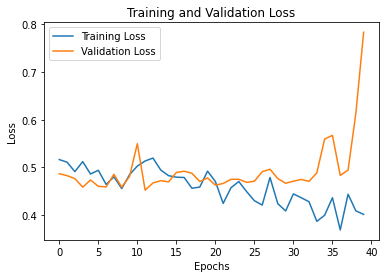

In [38]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

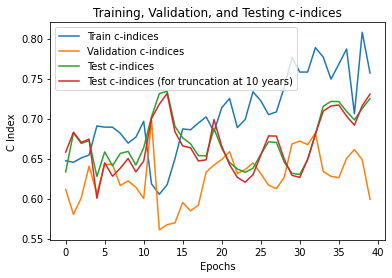

In [39]:
plt.plot(train_c_indices, label='Train c-indices')
plt.plot(val_c_indices, label='Validation c-indices')
plt.plot(test_c_indices, label='Test c-indices')
plt.plot(test_c_indices_trunc_10year, label='Test c-indices (for truncation at 10 years)')
plt.xlabel('Epochs')
plt.ylabel('C Index')
plt.title('Training, Validation, and Testing c-indices')
plt.legend()
plt.show()

# Get the node information of last hidden layer

#### Load trained model

In [47]:
best_state_dict = torch.load('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/WSI/Model_Saving/No_Dropout_with_AgeSexStage_WSIPhenoInteraction/model_best.pth')

#### Load predicted model

In [71]:
model_pred= WSI_Pred().to(device)
model_pred.load_state_dict(best_state_dict)

<All keys matched successfully>

In [72]:
model_pred.eval()
model_pred.train(False)

z_pred = []

with torch.no_grad():
    for idx,data in enumerate(test_loader):
        censors = torch.Tensor(data[0].censor)
        times = data[0].duration
        edge_index = data[0].edge_index.to(device)
        batch = data[0].batch.to(device)
        data_x = data[0].x.float().to(device)
        demographics = data[1].float().to(device)
        
        if torch.any(times.isnan()):
            times = torch.nan_to_num(times)
        if torch.any(censors.isnan()):
            censors = torch.nan_to_num(censors)        
        
        x, demo = model_pred(data_x, edge_index, batch, demographics)
        
        break

In [73]:
x.shape

torch.Size([5, 256])

In [74]:
data[1]

tensor([[77,  1,  0,  0,  0,  0,  1],
        [77,  0,  1,  0,  0,  0,  0],
        [77,  0,  1,  0,  0,  0,  0],
        [76,  0,  0,  0,  0,  0,  1],
        [76,  0,  0,  0,  0,  0,  1]])

In [75]:
data

[DataBatch(x=[86453, 2048], edge_index=[2, 778077], y=[86453, 2], pos=[86453, 2], censor=[5], duration=[5], batch=[86453], ptr=[6]),
 tensor([[77,  1,  0,  0,  0,  0,  1],
         [77,  0,  1,  0,  0,  0,  0],
         [77,  0,  1,  0,  0,  0,  0],
         [76,  0,  0,  0,  0,  0,  1],
         [76,  0,  0,  0,  0,  0,  1]])]

In [76]:
demographics.shape

torch.Size([5, 7])

In [79]:
test = outer(x,demographics)

In [80]:
test.shape

torch.Size([5, 1792])

In [67]:
2048/7

292.57142857142856

# Get the predicted hazard of DH dataset

##### Build prediction model

In [32]:
prediction_model = Network3().to(device)

##### Load trained model

In [33]:
best_state_dict = torch.load('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/WSI/Model_Saving/No_Dropout_with_AgeStandSexStage_WSIPhenoInteraction/model_epoch_10.pth')
best_state_dict

OrderedDict([('conv1.lin_l.weight',
              tensor([[ 0.0124,  0.0300, -0.0168,  ..., -0.0294, -0.0034,  0.0062],
                      [-0.0315, -0.0356, -0.0343,  ...,  0.0044, -0.0315,  0.0008],
                      [-0.0191, -0.0164, -0.0186,  ..., -0.0066, -0.0318, -0.0014],
                      ...,
                      [ 0.0005, -0.0021,  0.0077,  ..., -0.0170, -0.0325, -0.0194],
                      [-0.0067, -0.0350,  0.0055,  ...,  0.0193, -0.0054, -0.0216],
                      [ 0.0142, -0.0140,  0.0018,  ..., -0.0045, -0.0051,  0.0043]],
                     device='cuda:3')),
             ('conv1.lin_l.bias',
              tensor([ 6.7626e-04,  6.6705e-03,  1.0148e-03, -1.3752e-03,  1.0118e-02,
                       1.0870e-04,  8.3530e-03, -4.0474e-04,  1.1260e-04,  1.2103e-03,
                      -8.0212e-03,  5.8230e-03, -8.0358e-04,  4.5896e-03,  1.2073e-03,
                       2.5915e-03, -7.8168e-04, -2.4209e-03, -1.8910e-03, -1.4700e-03,
          

In [34]:
prediction_model.load_state_dict(best_state_dict)

<All keys matched successfully>

### Get hazards

In [35]:
hazards = []
prediction_model.eval()
prediction_model.train(False)
with torch.no_grad():
    for idx,data in enumerate(test_loader):
        censors = torch.Tensor(data[0].censor)
        times = data[0].duration
        edge_index = data[0].edge_index.to(device)
        batch = data[0].batch.to(device)
        data_x = data[0].x.float().to(device)
        demographics = data[1].float().to(device)
        if torch.any(times.isnan()):
            times = torch.nan_to_num(times)
        if torch.any(censors.isnan()):
            censors = torch.nan_to_num(censors)
            
        hazard_pred = prediction_model(data_x, edge_index, batch, demographics)
        
        hazards_pred = hazard_pred.cpu().numpy()
        
        for i in hazards_pred:
            hazards.append(i.item())

### Merge to the original data frame

In [38]:
predicted_df = clinical_DH_df[['FFPE.DNA.ID','Blood.Sample.ID','death_stat','death_censor_time','TenDead','TenYearSurv','RFS_stat','RFS_censor_time','TenRFS','TenYearRFS','Sex','Age']].copy()
predicted_hazards = hazards
predicted_df['predicted_hazard_WSI'] = predicted_hazards
predicted_df

,FFPE.DNA.ID,Blood.Sample.ID,death_stat,death_censor_time,TenDead,TenYearSurv,RFS_stat,RFS_censor_time,TenRFS,TenYearRFS,Sex,Age,predicted_hazard_WSI
0,BLD050,A00000FBK,1,3816.344970,0,120.0,1,3816.344970,0,120.000000,male,77,3.703560
1,BLD043,A00000FC3,1,4869.979467,0,120.0,1,4869.979467,0,120.000000,female,77,-2.134759
2,BLD043,A00000FC3,1,4869.979467,0,120.0,1,4869.979467,0,120.000000,female,77,-2.133028
3,BLD061,A00000EH7,0,3780.000000,0,120.0,0,3780.000000,0,120.000000,female,76,3.286664
4,BLD061,A00000EH7,0,3780.000000,0,120.0,0,3780.000000,0,120.000000,female,76,3.290863
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,BLD048,BDB1P03023,1,3609.363450,0,120.0,1,3609.363450,0,120.000000,male,58,-0.046455
132,BLD075,BDB1P04022,0,4230.000000,0,120.0,0,4230.000000,0,120.000000,male,51,-1.931617
133,BLD024,BDB1P02094,0,4500.000000,0,120.0,0,4500.000000,0,120.000000,male,68,2.871466
134,BLD094,BDB1P03058,0,4410.000000,0,120.0,1,1999.232877,1,66.641096,male,53,-1.449012


### Save

In [39]:
predicted_df.to_csv('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/WSI/predicted_hazards_WSI.csv')

### Get the node information of last hidden layer

In [32]:
model_pred= WSI_Pred().to(device)
model_pred.load_state_dict(best_state_dict)

<All keys matched successfully>

In [35]:
model_pred.eval()
model_pred.train(False)

z_pred = []

with torch.no_grad():
    for idx,data in enumerate(test_loader):
        censors = torch.Tensor(data.censor)
        times = data.duration
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)
        data = data.x.float().to(device)
        if torch.any(times.isnan()):
            times = torch.nan_to_num(times)
        if torch.any(censors.isnan()):
            censors = torch.nan_to_num(censors)        
        
        z = model_pred(data,edge_index,batch)
        
        z = z.cpu().numpy()
        
        for i in z:
            z_pred.append(i)

In [36]:
z_pred

[array([0.3994239 , 0.        , 0.7440072 , 0.        , 0.3060974 ,
        0.        , 0.        , 0.02920539, 0.48880175, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5228863 , 0.        , 0.27869278, 0.        , 0.3539335 ,
        0.        , 0.11911862, 0.        , 0.        , 0.        ,
        0.12695566, 0.4046006 , 0.        , 0.6385167 , 0.        ,
        0.01681564, 0.        , 0.17432554, 0.12685415, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.09508974,
        0.547302  , 0.09702948, 0.        , 0.31919345, 0.        ,
        0.        , 0.        , 0.        , 0.20337403, 0.12245215,
        0.        , 0.        , 0.5268814 , 0.        , 0.        ,
        0.        , 0.04374076, 0.11376603, 0.38868734, 0.61670923,
        0.        , 0.11969055, 0.        , 0.07492837, 0.6123605 ,
        0.4017089 , 0.5226917 , 0.        , 0.        , 0.37835515,
        0.19095469, 0.        , 0.        , 0.  

In [37]:
pd.DataFrame(z_pred)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.399424,0.0,0.744007,0.0,0.306097,0.0,0.0,0.029205,0.488802,0.0,...,0.0,0.0,0.064323,0.591547,0.504367,0.294732,0.0,0.0,0.0,0.335080
1,0.457536,0.0,0.741726,0.0,0.309833,0.0,0.0,0.060420,0.562768,0.0,...,0.0,0.0,0.072353,0.630623,0.452924,0.364347,0.0,0.0,0.0,0.289745
2,0.485036,0.0,0.730544,0.0,0.310723,0.0,0.0,0.038901,0.507698,0.0,...,0.0,0.0,0.070831,0.635739,0.423199,0.382570,0.0,0.0,0.0,0.310879
3,0.429829,0.0,0.723879,0.0,0.332099,0.0,0.0,0.046545,0.511501,0.0,...,0.0,0.0,0.093930,0.627801,0.453581,0.341706,0.0,0.0,0.0,0.333357
4,0.399697,0.0,0.721342,0.0,0.317145,0.0,0.0,0.047309,0.516416,0.0,...,0.0,0.0,0.077756,0.632303,0.476833,0.384121,0.0,0.0,0.0,0.324725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.478708,0.0,0.702546,0.0,0.269434,0.0,0.0,0.058673,0.496651,0.0,...,0.0,0.0,0.052243,0.638705,0.487886,0.303386,0.0,0.0,0.0,0.290237
132,0.457649,0.0,0.701540,0.0,0.297385,0.0,0.0,0.058825,0.507044,0.0,...,0.0,0.0,0.065961,0.606870,0.482033,0.265729,0.0,0.0,0.0,0.301132
133,0.396096,0.0,0.731287,0.0,0.326954,0.0,0.0,0.037319,0.583861,0.0,...,0.0,0.0,0.092855,0.623470,0.477870,0.325107,0.0,0.0,0.0,0.309577
134,0.439866,0.0,0.735426,0.0,0.308920,0.0,0.0,0.058488,0.504992,0.0,...,0.0,0.0,0.074392,0.622509,0.452955,0.349684,0.0,0.0,0.0,0.315777


In [38]:
pd.DataFrame(z_pred).to_csv('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/WSI/z_pred_test.csv')